# Read DVP data into the spatialdata format 

In this tutorial, we will read DVP data into the spatialdata format using DVP IO. We assume that cell segmentation was performed, e.g. in cellpose, and that the segmentation masks were processed and vectorized in BIAS and exported as LMD-compatible `.xml` files. We can now use spatialdata to further explore the data interactively, select shapes, etc. 

## Installation

In [ ]:
## Uncomment the following lines if you still need to create a suitable environment etc.
# conda create -n dvpio python=3.11 -y && conda activate dvpio
# pip install dvp-io

## Get data

We can get some mock data. Feel free to adjust the path to a suitable location

### Dataset
The mock data contains an image, segmented shapes in the LMD `.xml` file format, and the ground truth for the generation of the shapes as `.geojson` for comparison.

- mock-data/blobs

    - images
    
        - binary-blobs.tiff

    - shapes
    
        - all_tiles_contours.xml
        - middle_tiles_contours.xml

    - ground_truth 
        - binary-blobs.segmentation.geojson

In [7]:
# %%capture
# %%bash 
# downloadpath="./mock-data"
# mkdir -p $downloadpath 
# wget -O $downloadpath/blobs.zip "https://datashare.biochem.mpg.de/s/0oTGB6xpUaWIaVh/download"
# unzip -d $downloadpath $downloadpath/blobs.zip
# rm $downloadpath/blobs.zip

## Read with DVP IO 

We will now try to read in the data to the spatialdata format. This involves the following steps:

1. Generate spatialdata object 
2. Read image 
3. Read calibration points 
4. Read segmentation masks and align via calibration points
5. *Optional*: Write spatialdata

In [3]:
import spatialdata
import spatialdata_plot  # noqa
from napari_spatialdata import Interactive  # noqa

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [4]:
from dvpio.read.image import read_custom
from dvpio.read.shapes import read_lmd

### Initialize spatialdata 
First, we initialize an empty spatialdata object

In [5]:
sdata = spatialdata.SpatialData()
sdata

SpatialData object
with coordinate systems:

### Read image
Then, we read an image. In this case, we are dealing with a tiff file, so we will be using the `dvpio.image.read_custom` function that natively supports tiff images. The function parses the file directly into the spatialdata-compatible format, so that you can just add it to the `spatialdata.image` attribute


#### Alternative readers
If you were working with `.czi` files, you would instead use the `read_czi` reader function. Similarly, you would use the `read_openslide` reader for `openslide` compatible whole slide images.

In [8]:
img = read_custom("./mock-data/blobs/images/binary-blobs.tiff")
img

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


<xarray.DataArray 'image' (c: 1, y: 1024, x: 1024)> Size: 8MB
dask.array<getitem, shape=(1, 1024, 1024), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 8kB 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
  * x        (x) float64 8kB 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
Attributes:
    transform:  {'global': Identity }

We can now add the image to the spatialdata.images attribute

In [9]:
# Assign to spatialdata.images slot
sdata.images["blobs"] = img
sdata

SpatialData object
└── Images
      └── 'blobs': DataArray[cyx] (1, 1024, 1024)
with coordinate systems:
    ▸ 'global', with elements:
        blobs (Images)

### Identify calibration points 
To align the image with the segmented cells, we need to pick the calibration points in the image. We can do this interactively in the Napari Viewer.

> The calibration points are small squares in the bottom left, top left, and top right corner of the image.

In [10]:
## Uncomment to run
# interactive = Interactive(sdata)
# interactive.add_element("blobs", element_coordinate_system="global")
# interactive.run()

#### Picking calibration points 

1. Create a new `points` layer in the napari viewer. 
2. *Recommended*: Rename the layer to a more expressive name, e.g. `calibration_points_image`
3. Select the 3 calibration points. **Currently, you have to pick them in the correct order, as they are defined in the lmd/.xml file.** (Here: _1. bottom left, 2. top left, 3. top right_)
4. Save the layer by clicking `Shift+E`
5. Leave the napari viewer.

The calibration points were added to the `shapes` attribute of the spatialdata object


![Picking calibration points](../_static/img/napari-tutorial1.gif)

In [11]:
# Uncomment to assign ground truth values
import numpy as np

sdata.points["calibration_points_image"] = spatialdata.models.PointsModel.parse(
    np.array([[15, 1015], [15, 205], [1015, 15]])
)

In [12]:
sdata

SpatialData object
├── Images
│     └── 'blobs': DataArray[cyx] (1, 1024, 1024)
└── Points
      └── 'calibration_points_image': DataFrame with shape: (<Delayed>, 2) (2D points)
with coordinate systems:
    ▸ 'global', with elements:
        blobs (Images), calibration_points_image (Points)

### Read segmentation masks from LMD `.xml`

You can now load the segmentation masks from the LMD formatted `.xml` file, using the designated `read_lmd` function. The function returns a `geopandas.GeoDataFrame` that can be immediately passed to the spatialdata.shapes attribute

In [13]:
sdata.shapes["segmentation_masks"] = read_lmd(
    "./mock-data/blobs/shapes/all_tiles_contours.xml",
    calibration_points_image=sdata.points["calibration_points_image"],
    switch_orientation=False,
)

sdata.shapes["segmentation_masks"]

,name,well,geometry
0,Shape_1,None,"POLYGON ((-0.603 0.518, -0.603 1.518, -0.603 2..."
1,Shape_2,None,"POLYGON ((-0.603 120.518, -0.603 121.518, -0.6..."
2,Shape_3,None,"POLYGON ((9.397 200.518, 9.397 201.518, 9.397 ..."
3,Shape_4,None,"POLYGON ((38.397 219.518, 37.397 220.518, 36.3..."
4,Shape_5,None,"POLYGON ((143.397 334.718, 142.397 335.718, 14..."
...,...,...,...
57,Shape_58,None,"POLYGON ((729.997 410.718, 728.997 411.718, 72..."
58,Shape_59,None,"POLYGON ((824.997 422.718, 823.997 423.718, 82..."
59,Shape_60,None,"POLYGON ((859.997 590.918, 858.997 591.918, 85..."
60,Shape_61,None,"POLYGON ((944.997 863.118, 943.997 864.118, 94..."


We can now inspect the results as static images or in a dynamic Napari session. We see that the segmentation masks and blobs overlay reasonably well. 

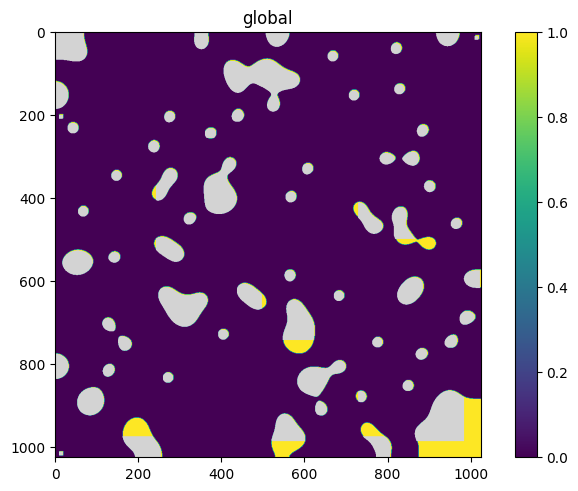

In [14]:
sdata.pl.render_images("blobs").pl.render_shapes("segmentation_masks").pl.show(coordinate_systems="global")

### Write 

If you would like to keep a persistent copy of your spatialdata object on disk, use the write functionality:

In [15]:
sdata.write("./mock-data/blobs/sdata/my_sdata.zarr")

INFO     The Zarr backing store has been changed from None the new file path: mock-data/blobs/sdata/my_sdata.zarr  
